# Лабораторная работа 6

## 1. Анализ и предобработка.

Загрузка

In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

movies = pd.read_csv("mkrf_movies.csv")
shows = pd.read_csv("mkrf_shows.csv")


Приведение типов,  Объединение по puNumber и обрабтка дат

In [4]:
movies["puNumber"] = movies["puNumber"].astype(str)
shows["puNumber"] = shows["puNumber"].astype(str)

# === 2. ===
df = movies.merge(shows, on="puNumber", how="left")
df["box_office"] = df["box_office"].fillna(0)

# === 3. Заполнение пропусков ===
text_cols = ["film_studio", "director", "producer", "genres"]
for col in text_cols:
    df[col] = df[col].fillna("unknown")

num_cols = ["budget", "refundable_support", "nonrefundable_support"]
for col in num_cols:
    df[col] = df[col].fillna(0)

# === 4. Обработка дат ===
df["show_start_date"] = pd.to_datetime(df["show_start_date"], errors="coerce")
df["year"] = df["show_start_date"].dt.year.fillna(0).astype(int)
df["month"] = df["show_start_date"].dt.month.fillna(0).astype(int)

Преобразование жанров в мульти-хот код

In [5]:
df["genres"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else ["unknown"])
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df["genres"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])
df = pd.concat([df, genres_df], axis=1)

One-Hot Encoding для категориальных признаков

In [6]:
df = pd.get_dummies(df, columns=["type", "age_restriction", "financing_source"], drop_first=True)

Обработка целевой переменной

In [7]:
df["ratings"] = pd.to_numeric(df["ratings"], errors="coerce")
df = df.dropna(subset=["ratings"])

Масштабирование числовых признаков

In [8]:
scaler = StandardScaler()
scale_cols = ["budget", "refundable_support", "nonrefundable_support", "box_office"]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

Проверяю и принчу всё подряд

In [9]:

print(df.info())

print("Пропуски")
print(df.isna().sum().sort_values(ascending=False).head(10))

print(df.head(3))

print("\n статиситка")
print(df[scale_cols + ["ratings"]].describe().T)

print("\nПризнаки после кодирования")
print(f"Количество жанровых колонок: {len([c for c in df.columns if c.startswith('genre_')])}")
print(f"Количество категориальных колонок: {len([c for c in df.columns if c.startswith(('type_', 'age_restriction_', 'financing_source_'))])}")
print(f"Итого признаков: {df.shape[1]} и строк: {df.shape[0]}")


<class 'pandas.core.frame.DataFrame'>
Index: 6490 entries, 0 to 7485
Data columns (total 58 columns):
 #   Column                                             Non-Null Count  Dtype              
---  ------                                             --------------  -----              
 0   title                                              6490 non-null   object             
 1   puNumber                                           6490 non-null   object             
 2   show_start_date                                    6490 non-null   datetime64[ns, UTC]
 3   film_studio                                        6490 non-null   object             
 4   production_country                                 6488 non-null   object             
 5   director                                           6490 non-null   object             
 6   producer                                           6490 non-null   object             
 7   refundable_support                                 6490 non-null 

## 2. Построение baseline-модели нейронной сети

Импорты и отбор данных

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError

X = df.drop(columns=[
    "ratings", "title", "puNumber", "show_start_date",
    "film_studio", "director", "producer", "production_country", "genres"
])
y = df["ratings"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Создание Baseline модели

In [11]:

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # регрессия — без активации
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[RootMeanSquaredError()]
)


c:\Users\roma\CODE\vscode_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучение и оценка

In [12]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

loss, rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"\nBaseline RMSE: {rmse:.4f}")

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2873.3518 - root_mean_squared_error: 53.6037 - val_loss: 1.1303 - val_root_mean_squared_error: 1.0632
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2380 - root_mean_squared_error: 1.1127 - val_loss: 1.1281 - val_root_mean_squared_error: 1.0621
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2361 - root_mean_squared_error: 1.1118 - val_loss: 1.1298 - val_root_mean_squared_error: 1.0629
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2333 - root_mean_squared_error: 1.1106 - val_loss: 1.0993 - val_root_mean_squared_error: 1.0485
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2204 - root_mean_squared_error: 1.1047 - val_loss: 1.0895 - val_root_mean_squared_error: 1.0438
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2348 - root_mean_squared_error: 1.1112 - val_loss: 1.1715 - val_root_mean_squared_error: 1.0824
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

График

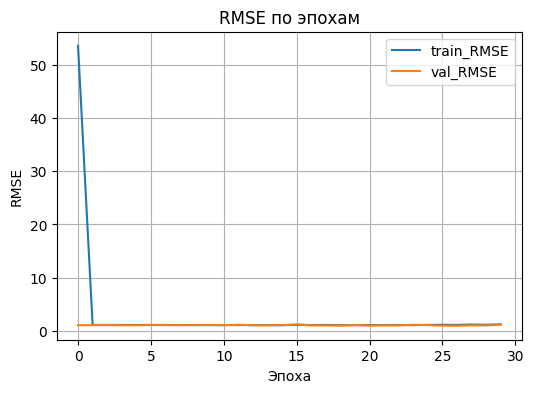

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['root_mean_squared_error'], label='train_RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='val_RMSE')
plt.title('RMSE по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
X = df.drop(columns=[
    "ratings", "title", "puNumber", "show_start_date",
    "film_studio", "director", "producer", "production_country", "genres"
])
y = df["ratings"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Класс модели

In [16]:
class MovieRatingModel:
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build_model(self, activation='relu', dropout_rate=0.0, use_batchnorm=False):
        model = Sequential()
        model.add(Dense(64, activation=activation, input_shape=(self.input_dim,)))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation=activation))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))  # выходной слой без активации
        model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])
        return model


Грид для подбора и перебор гиперпараметров

In [ ]:
activations = ['relu', 'tanh', 'elu']
dropouts = [0, 0.3, 0.5]
batchnorms = [False, True]
batch_sizes = [16, 32, 64]

results = []

# Перебираем все комбинации
for act, dr, bn, bs in itertools.product(activations, dropouts, batchnorms, batch_sizes):
    model = MovieRatingModel(X_train.shape[1]).build_model(activation=act, dropout_rate=dr, use_batchnorm=bn)
    history = model.fit(X_train, y_train, epochs=20, batch_size=bs, verbose=0, validation_data=(X_test, y_test))
    rmse = history.history['val_root_mean_squared_error'][-1]
    results.append({
        'activation': act,
        'dropout': dr,
        'batchnorm': bn,
        'batch_size': bs,
        'val_RMSE': rmse
    })




c:\Users\roma\CODE\vscode_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\roma\CODE\vscode_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\roma\CODE\vscode_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_

Результат и взуализация


=== ЛУЧШАЯ МОДЕЛЬ ===
activation        relu
dropout            0.0
batchnorm        False
batch_size          16
val_RMSE      0.956348
Name: 0, dtype: object


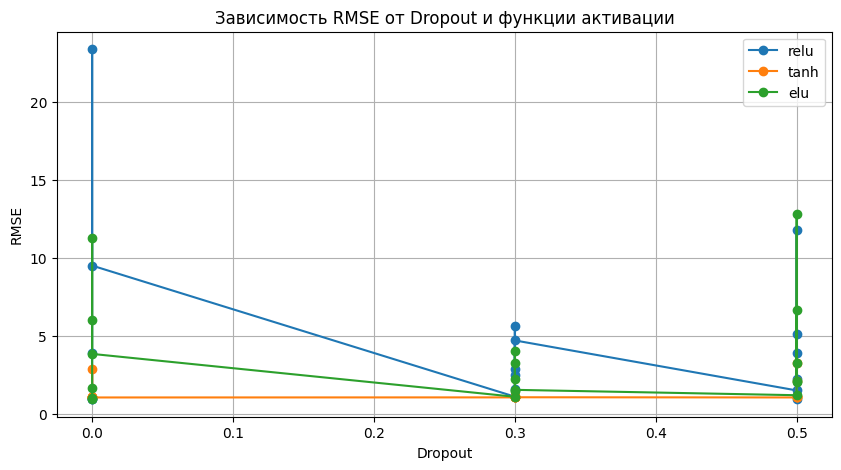

In [ ]:

results_df = pd.DataFrame(results)
best = results_df.sort_values(by='val_RMSE').iloc[0]
print("\n=== ЛУЧШАЯ МОДЕЛЬ ===")
print(best)

plt.figure(figsize=(10, 5))
for act in activations:
    subset = results_df[results_df['activation'] == act]
    plt.plot(subset['dropout'], subset['val_RMSE'], marker='o', label=act)
plt.title('Зависимость RMSE от Dropout и функции активации')
plt.xlabel('Dropout')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()